In [ ]:
!pip install tensorflow-io

     |████████████████████████████████| 22.7 MB 1.1 MB/s 
     |████████████████████████████████| 2.3 MB 74.9 MB/s 


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 679 kB 8.1 MB/s 


In [ ]:
! pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-b6bnn2pa
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-b6bnn2pa
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=89e5bc360d51bd19294ea89c2dbf2f2602855a6f27f88bb5a1077d8ab15bdc83
  Stored in directory: /tmp/pip-ephem-wheel-cache-e_y2vk3j/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [ ]:
# Importing the necessary libraries
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import label_ranking_average_precision_score

from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#Global variables
img_ht=384
img_wt=768
sample_rate=48000
num_class=24
num_mels=384
f_min=40
f_max=24000
batch_size=8
#(train_pts/batch_size)
steps_per_epoch=140

In [ ]:
# Loading the dataset 
train_tp = pd.read_csv('/content/drive/MyDrive/Appliedai files/Case_Study_2/train_tp.csv')
train_tp

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20


In [ ]:
# Loading the test data files
test = os.listdir('/content/drive/MyDrive/Appliedai files/Case_Study_2/test')

In [ ]:
# Splitting the train true positive data into train and validation
train, validation = train_test_split(train_tp, test_size = 0.1, stratify = train_tp['species_id'])

In [ ]:
#https://www.tensorflow.org/io/tutorials/audio?hl=pt

def create_mel_spectrogram(file):

    """ This function reads the file and computes the mel spectrogram and returns the spectrogram"""
    audio = tfio.IOTensor.graph(tf.int16).from_audio(file)
    audio_slice = audio[100:]

    # remove last dimension
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=2048, window=2048, stride=512)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=num_mels, fmin=f_min, fmax=f_max)
    mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Expanding the dimensions of spectrograms by 1 
    image = tf.expand_dims(mel_spectrogram, axis= -1)
    image = tf.image.resize(image, [img_ht, img_wt])
    image = tf.image.grayscale_to_rgb(image)

    # Returning mel_spectrogram
    return image

In [ ]:
#https://www.tensorflow.org/tutorials/images/data_augmentation

def augmentation(spectrogram,label):

  #in this function we perform data augmentations on the spectrogram images for train data
  
  k=np.random.uniform()
  if k<0.25:
    spectrogram = tf.image.flip_up_down(spectrogram)

  elif k<0.5:
    spectrogram= tf.image.flip_left_right(spectrogram)

  elif k<0.75:
    spectrogram= tf.image.random_contrast(spectrogram,0.2,0.5)

  else:
    spectrogram = tf.image.random_brightness(spectrogram,0.2)

  return spectrogram,label

In [ ]:
def preprocess_train(file):

  #Preprocessing the train data

  image=create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')

  #one hot encoding of the target labels
  label= tf.one_hot(file['species_id'],num_class)

  return image,label

def preprocess_val(file):

  #Preprocessing the validation data

  image=create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')

  #one hot encoding of the target labels
  label= tf.one_hot(file['species_id'],num_class)

  return image,label


def preprocess_test(file):

  #Preprocessing the test data

  image=create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/test/'+file)

  #getting the file ids
  file_name=tf.strings.split(file,'.')[0]

  return image,file_name


In [ ]:
# Creating a dataset from train data and mapping the preprocess train function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = files_ds.map(preprocess_train).cache().map(augmentation).shuffle(3).batch(batch_size).prefetch(-1).repeat()

# Creating a dataset from validation data and mapping the preprocess val function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = files_ds.map(preprocess_val).cache().shuffle(3).batch(batch_size).prefetch(-1)

# Creating a dataset from test data and mapping the preprocess test function
files_ds = tf.data.Dataset.from_tensor_slices(test)
test_dataset = files_ds.map(preprocess_test).cache().shuffle(3).prefetch(-1)

In [ ]:
def lrap(y_true, y_pred):
    return tf.py_function(label_ranking_average_precision_score, (y_true, y_pred), tf.double)

In [ ]:
backbone = tf.keras.applications.DenseNet121(include_top = False,input_shape = (img_ht,img_wt,3), weights="imagenet")

for layer in backbone.layers[:0]:
    layer.trainable = False

model = tf.keras.Sequential([
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_class,bias_initializer=tf.keras.initializers.Constant(-2.))])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 12, 24, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
Total params: 7,172,312
Trainable params: 7,088,408
Non-trainable params: 83,904
_________________________________________

In [ ]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=2e-3,total_steps=30*140,warmup_proportion=0.3,min_lr=1e-6), loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits = True), metrics=[lrap])

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/CS2/Logs/Densenet121_not_overfitting'),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_2/{epoch:02d}-{lrap:.4f}-{val_lrap:.4f}.h5', save_weights_only=True)]

In [ ]:
model.fit(train_dataset,steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_dataset,epochs = 35,callbacks = callbacks)

Epoch 1/35
140/140 [==============================] - 2871s 20s/step - loss: 0.7980 - lrap: 0.1650 - val_loss: 0.5817 - val_lrap: 0.1451
Epoch 2/35
140/140 [==============================] - 37s 265ms/step - loss: 0.6082 - lrap: 0.2176 - val_loss: 1.3975 - val_lrap: 0.1680
Epoch 3/35
140/140 [==============================] - 37s 263ms/step - loss: 0.4806 - lrap: 0.2744 - val_loss: 1.6733 - val_lrap: 0.1825
Epoch 4/35
140/140 [==============================] - 37s 265ms/step - loss: 0.4317 - lrap: 0.2993 - val_loss: 0.5685 - val_lrap: 0.2227
Epoch 5/35
140/140 [==============================] - 37s 264ms/step - loss: 0.3936 - lrap: 0.3495 - val_loss: 3.1818 - val_lrap: 0.1862
Epoch 6/35
140/140 [==============================] - 37s 265ms/step - loss: 0.3765 - lrap: 0.3652 - val_loss: 2.4520 - val_lrap: 0.1691
Epoch 7/35
140/140 [==============================] - 37s 264ms/step - loss: 0.3516 - lrap: 0.4128 - val_loss: 0.7596 - val_lrap: 0.3409
Epoch 8/35
140/140 [=====================

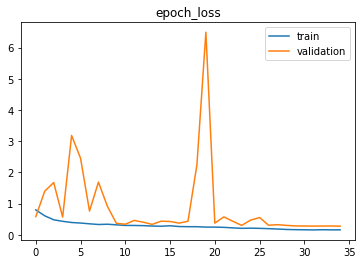

In [ ]:
epochs=[i for i in range(35)]
# plot lines
plt.plot(epochs,loss,label='train')
plt.plot(epochs,val_loss,label='validation')
plt.title('epoch_loss')
plt.legend()
plt.show()

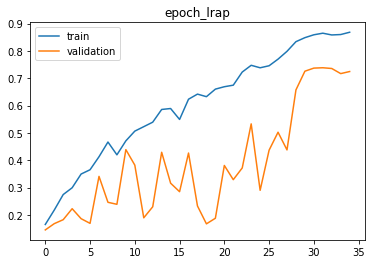

In [ ]:
# plot lines
plt.plot(epochs,lrap,label='train')
plt.plot(epochs,val_lrap,label='validation')
plt.title('epoch_lrap')
plt.legend()
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_2/32-0.8647-0.7383.h5')

In [ ]:
from tqdm import tqdm
y_pred = []
recording_id = []

for image,file_name in tqdm(test_dataset.batch(1)):
  pred = tf.sigmoid(model(image)).numpy()
  y_pred.append(pred)
  recording_id.append(file_name)



  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 1/1992 [00:04<2:35:40,  4.69s/it]

  0%|          | 2/1992 [00:05<2:01:42,  3.67s/it]

  0%|          | 3/1992 [00:09<1:56:04,  3.50s/it]

  0%|          | 4/1992 [00:11<1:43:41,  3.13s/it]

  0%|          | 5/1992 [00:13<1:32:21,  2.79s/it]

  0%|          | 6/1992 [00:15<1:24:34,  2.56s/it]

  0%|          | 7/1992 [00:17<1:20:19,  2.43s/it]

  0%|          | 8/1992 [00:20<1:25:45,  2.59s/it]

  0%|          | 9/1992 [00:22<1:19:45,  2.41s/it]

  1%|          | 10/1992 [00:24<1:20:51,  2.45s/it]

  1%|          | 11/1992 [00:27<1:17:06,  2.34s/it]

  1%|          | 12/1992 [00:29<1:13:48,  2.24s/it]

  1%|          | 13/1992 [00:31<1:14:33,  2.26s/it]

  1%|          | 14/1992 [00:33<1:13:48,  2.24s/it]

  1%|          | 15/1992 [00:35<1:15:31,  2.29s/it]

  1%|          | 16/1992 [00:38<1:18:15,  2.38s/it]

  1%|          | 17/1992 [00:41<1:19:15,  2.41s/it]

  1%|          | 18/1992 [00:43<1:21:12,  2.47s/it]

  1%|      

In [ ]:
test_pred=np.asarray(y_pred,dtype='float16')
test_pred=test_pred.reshape(1992,24)

In [ ]:
column_names=[]

for i in range(24):
  column_names.append('s'+str(i))

df_index=[i for i in range(1992)]

test_recording_id=[]
for i in recording_id:
  k=i.numpy()
  k=str(k)
  test_recording_id.append(k[3:-2])


results_df=pd.DataFrame(data=test_pred,index=df_index,columns=column_names)

results_df['recording_id']=test_recording_id

In [ ]:
new_results=results_df.reindex(columns=['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18',
                            's19','s20','s21','s22','s23'])

new_results.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,7c712b45f,0.062042,0.062988,0.042450,0.146606,0.076599,0.064148,0.125366,0.090637,0.066711,0.177490,0.096069,0.140625,0.100647,0.030319,0.069580,0.102234,0.105957,0.285400,0.090027,0.065186,0.184204,0.076233,0.057892,0.257568
1,7d064b789,0.867676,0.048706,0.071655,0.101868,0.042114,0.052277,0.032898,0.056000,0.044128,0.052216,0.034271,0.048187,0.118347,0.013611,0.030762,0.061859,0.017563,0.083069,0.096802,0.008286,0.031860,0.016266,0.038757,0.024963
2,7df2eb324,0.048950,0.047119,0.035217,0.150391,0.072876,0.093140,0.103760,0.061462,0.079468,0.197632,0.072021,0.135498,0.155518,0.049774,0.047302,0.069458,0.093811,0.156494,0.071167,0.067871,0.150513,0.050873,0.060883,0.609863
3,7d188d367,0.137085,0.093079,0.119507,0.208618,0.208252,0.113281,0.087708,0.133789,0.091248,0.103821,0.039001,0.182373,0.385986,0.051483,0.057739,0.062927,0.018463,0.049866,0.299805,0.050720,0.135986,0.069641,0.076294,0.067566
4,7e025e0bf,0.064270,0.059387,0.047516,0.114563,0.046478,0.074707,0.042542,0.459961,0.074341,0.028275,0.033173,0.141113,0.055298,0.059082,0.203369,0.391602,0.068054,0.078308,0.050934,0.101746,0.125610,0.050110,0.079651,0.074219


In [ ]:
new_results.to_csv('/content/drive/MyDrive/Appliedai files/Case_Study_2/submission_4.csv',index=False)